# Confluency calculation and plotting

Using output from FiJi confluency_counter, calculates mean estimated confluency according to sample list. Returns summary dataframe containing averaged and annotated data, and scattbar plot.
Important variables to change include input and output paths, and the sample coords. This section assumes files are labelled 
systematically i.e. 1_A_1 refers to plate 1, row A, column 1

In [17]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger
from GEN_Utils import FileHandling

Set variables specific for the dataset

In [19]:
input_folder = 'fiji/'
output_path = 'python/confluency/'
plate_1_sample = ['TPE only', '1', '1.5', '2', '3', '4']
plate_2_sample = ['PI only', 'No stain', 'Control', 'SFM']
x_label = r'Density (x 10$^5$)'
plate_names = ['Densities', 'Controls']

In [20]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
# Determine available data sets as folders

folder_list = sorted([foldername[1] for foldername in os.walk(input_folder)][0])
# Generate sample map

plate_cords = [f'{x}_{y}' for x in range (1, 3) for y in range (1, 7)]
sample_map = dict(zip(plate_cords, (plate_1_sample+plate_2_sample)))

Read in and preprocess all summary measurements in each folder

In [21]:
day_dict = {}

for x, day in enumerate(folder_list):
    day_name = day.split('/')[-1]
    # Read in results from Day 1
    day_raw = pd.read_csv(f'{input_folder}{day}/_Measurements.csv')
    ## append more useable sample labels
    day_cleaning = day_raw.copy()
    # determine well number - this is specific to the naming system of the images!
    day_cleaning['Well #'] = day_cleaning['Label'].str.split(' - ', expand=True)[0]
    day_cleaning['Plate #'] = day_cleaning['Well #'].str.split('_', expand=True)[0]
    day_cleaning['Treatment #'] = day_cleaning['Well #'].str.split('_', expand=True)[2]
    day_cleaning['Plate_coords'] = day_cleaning['Plate #'].map(str) +'_' + day_cleaning['Treatment #'].map(str)
    day_cleaning['day'] = x + 1
    day_cleaning['sample'] = day_cleaning['Plate_coords'].map(sample_map)
    day_dict[day_name] = day_cleaning

In [22]:
summary_df = pd.concat(day_dict.values())
summary_df.head()

Reformat summary data to enable plotting

In [24]:
plotting_plates = []

for group, data in summary_df.groupby('Plate #'):
        plot_df = data[['Well #', 'sample', 'day', '%Area']].reset_index()
        # Exclude unused wells to allow easier plotting
        plot_df = plot_df[plot_df['sample'] != 'Unused']
        plot_df['Hue position'] = plot_df['day'].astype("category").cat.codes
        plotting_plates.append(plot_df)

Generate scattbar plot

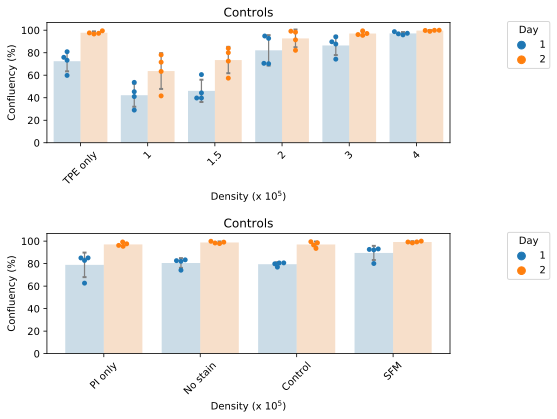

In [25]:
dimensions = len(set(summary_df['Plate #']))
fig, axes = plt.subplots(dimensions, 1, figsize=(8, dimensions*3))

for x, plate in enumerate(plotting_plates):
    # Generate figures
    br = sns.barplot(x='sample', y='%Area', data=plate, hue='day', dodge=True,errwidth=1.25,alpha=0.25,ci=None, ax=axes[x])
    scat = sns.swarmplot(x='sample', y='%Area', data=plate, hue='day', dodge=True, ax=axes[x])
    # To generate custom error bars
    sample_list = list(plate['sample'].dropna().unique())
    number_groups = len(list(set(plate['Hue position'])))
    bars = br.patches
    xvals = [(bar.get_x() + bar.get_width()/2) for bar in bars]
    xvals.sort()
    # collect mean, sd for each bar
    yvals = plate.groupby(["sample", "Hue position"]).mean().T[sample_list].T
    yvals.reset_index(inplace=True)
    yvals.rename(columns={'%Area':'mean'}, inplace=True)
    yvals['error'] = list(plate.groupby(
        ["sample", "Hue position"]).std().T[sample_list].T['%Area'])
    yvals = yvals.sort_values(["sample", "Hue position"]).set_index('sample').T[sample_list].T
    (_, caps, _) = axes[x].errorbar(x=xvals,y=yvals['mean'],yerr=yvals['error'],capsize=2,elinewidth=1.25,ecolor="grey", linewidth=0)
    for cap in caps:
        cap.set_markeredgewidth(2)
    axes[x].set_ylabel("Confluency (%)")
    # To only label once in legend
    handles, labels = axes[x].get_legend_handles_labels()
    axes[x].legend(handles[0:number_groups], labels[0:number_groups], bbox_to_anchor=(1.26, 1.05), title='Day')
    # rotate tick labels
    for label in axes[x].get_xticklabels():
        label.set_rotation(45)

plt.ylabel("Confluency (%)")

for ax in axes:
    ax.set_xlabel(x_label)
    ax.set_title(plate_names[x])

plt.tight_layout()
plt.autoscale()